# Expected price & return
* Increase test window and the squared returns instead of rolling volatiity to dynamically switch regime, and forecast volatility.
* Uses monte carlo simulation to probabilistic estimate of return in next time steps.
* Unfold forecasted returns to compute price and plot price chart.

## Import & Setup Parameters

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from hmmlearn.hmm import GaussianHMM # for 2 state regime detection
from sklearn.preprocessing import StandardScaler, RobustScaler # transform for HMM/regime detection

from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

In [17]:
# parameters
SEED = 42
target = 1
horizon = 21*3
rolling_var = 21 
regime_window = 15

## Data Preparation

In [ ]:
df = yf.download('MSFT', start='2014-01-01', auto_adjust=True, progress=False)
df.dropna(inplace=True)
df['LogReturn'] = np.log(df['Close']).diff()
df["pctLogReturn"] = df['LogReturn'] * 100 
df.dropna(inplace=True, axis=0)
df_train, df_test = df[:'2022-01-01'], df['2022-01-01':]


Our pct log returns have t-distribution, student's t-HMM would like perform better. 

In [213]:
def ghmm(train, test, name='', **params):
    model = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000, random_state=SEED, tol=1e-10, **params)
    if not isinstance(train, np.ndarray):
        X = train.values.reshape(-1, 1)
        X_ = test.values.reshape(-1, 1)

    model.fit(X)
    
    print(name, 'show', model.monitor_.converged, 'convergence')
    print('Training score', model.score(X)/len(X[0]))
    print('Testing score', model.score(X_)/len(X_[0]))

    print("Means per regime:")
    print(model.means_)

    print("Covariances per regime:")
    print(model.covars_)
    
    plt.figure(figsize=(10,3))
    plt.scatter(test.index, X_, c=model.predict(X_), s=6, cmap='tab10')
    plt.title(f'HMM regime color for {name}'); plt.show()

Model is not converging.  Current: 5751.276886737859 is not greater than 5751.285074711583. Delta is -0.00818797372357949


log-return data show True convergence
Training score 5751.251080758384
Testing score 2803.295294030983
Means per regime:
[[ 0.00156702]
 [-0.00133889]]
Covariances per regime:
[[[0.00012942]]

 [[0.00122175]]]


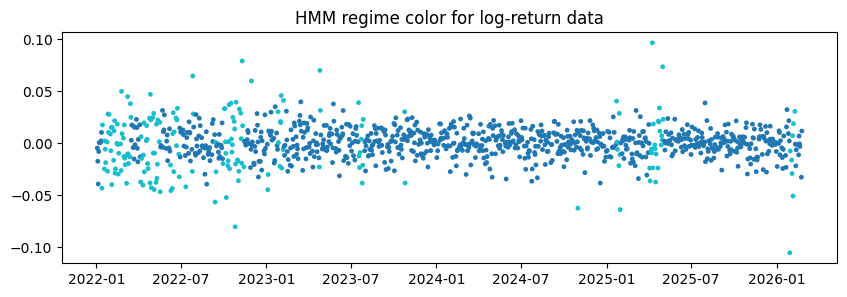

In [214]:
ghmm(df_train[['LogReturn']], df_test[['LogReturn']], name='log-return data')

Model is not converging.  Current: 6678.113895995491 is not greater than 6678.135417759738. Delta is -0.02152176424715435


absolute log return show True convergence
Training score 6677.522693880504
Testing score 3318.1680303437374
Means per regime:
[[0.02820394]
 [0.00763272]]
Covariances per regime:
[[[4.15613089e-04]]

 [[4.14624592e-05]]]


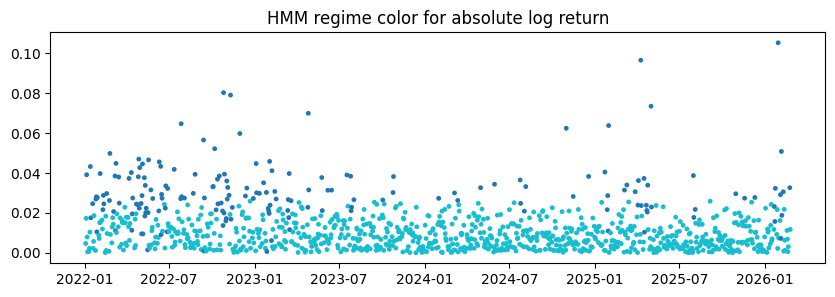

In [216]:
ghmm(df_train['absLogReturn'], df_test['absLogReturn'], name='absolute log return')

percent log return show True convergence
Training score -1.7476585981653465
Testing score -1.9021300548275024
Means per regime:
[[ 0.15924555]
 [-0.05581105]]
Covariances per regime:
[[[1.07020656]]

 [[9.3158356 ]]]


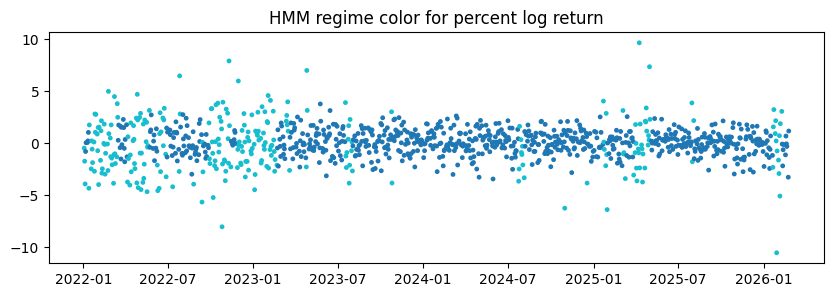

In [ ]:
def prepare_features(returns):
    df = pd.DataFrame()
    df['returns'] = returns
    df['rolling_vol'] = returns.rolling(21).std()  # 21-day rolling vol
    return df.dropna()

# Then reshape for HMM
X = features[['returns', 'rolling_vol']].values  # shape (n, 2)

In [246]:
features = df_train['LogReturn'].rolling(rolling_var).std()
features.name = 'rolling_vol'
features = pd.concat([features, df_train['LogReturn']], axis=1).dropna()

Converged: True
Means:
 [[0.00146388 0.01137954]
 [0.00019945 0.02495597]]


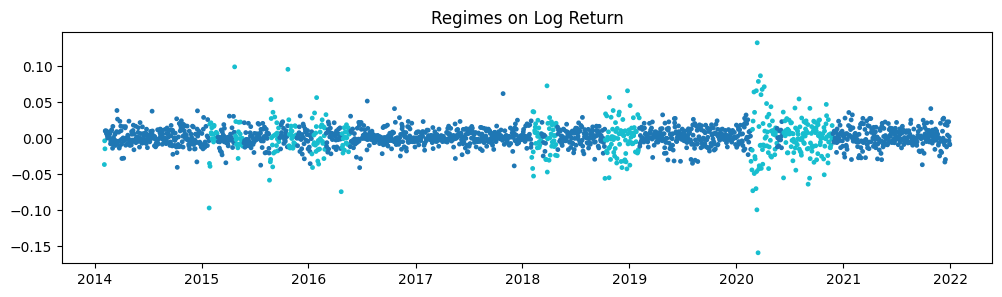

In [247]:
X = features[['LogReturn', 'rolling_vol']].values

model = GaussianHMM(n_components=2, covariance_type='full', 
                    n_iter=1000, random_state=42, tol=1e-10)
model.fit(X)

print("Converged:", model.monitor_.converged)
print("Means:\n", model.means_)

regimes = pd.Series(model.predict(X), index=features.index)

plt.figure(figsize=(12, 3))
plt.scatter(features.index, features['LogReturn'], 
            c=regimes, s=6, cmap='tab10')
plt.title('Regimes on Log Return')
plt.show()

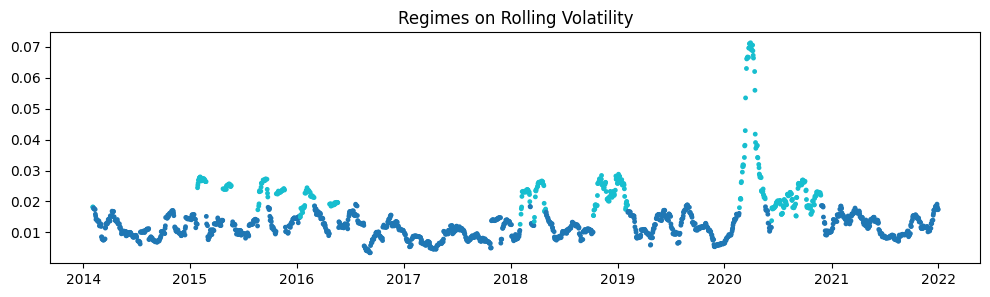

In [248]:
plt.figure(figsize=(12, 3))
plt.scatter(features.index, features['rolling_vol'], 
            c=regimes, s=6, cmap='tab10')
plt.title('Regimes on Rolling Volatility')
plt.show()

In [249]:
# Identify which state is high vol
high_vol_state = model.means_[:, 1].argmax()  # whichever has higher rolling_vol mean

regime_labels = regimes.map({high_vol_state: 'high', 1 - high_vol_state: 'low'})

# Split returns by regime
low_returns = features.loc[regime_labels == 'low', 'LogReturn']
high_returns = features.loc[regime_labels == 'high', 'LogReturn']

print("Low regime days:", len(low_returns))
print("High regime days:", len(high_returns))

Low regime days: 1540
High regime days: 454


HMM gave 30% High regime, which were only 5% in hysteresis based volatility regime 

In [245]:
# GARCH on low volatility regime
garch_model = arch_model(low_returns, vol='GARCH', p=1, q=1, dist='normal')
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6570.24
Distribution:                  Normal   AIC:                          -13132.5
Method:            Maximum Likelihood   BIC:                          -13109.7
                                        No. Observations:                 2171
Date:                Wed, Feb 25 2026   Df Residuals:                     2170
Time:                        15:27:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.3378e-03  2.435e-04      5.493  3.952e-08 [8.

In [ ]:
# egarch for high regime
egarch_model = arch_model(high_returns, vol='EGARCH', p=1, q=1, dist='normal')
egarch_fit = egarch_model.fit(disp='off')
print(egarch_fit.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                1995.21
Distribution:                  Normal   AIC:                          -3982.41
Method:            Maximum Likelihood   BIC:                          -3963.38
                                        No. Observations:                  862
Date:                Wed, Feb 25 2026   Df Residuals:                      861
Time:                        15:27:27   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.0120e-03  8.741e-04      1.158      0.247 

In [ ]:
if 

array([0, 1, 1, ..., 0, 1, 0], shape=(1039,))